In [1]:
from copy import deepcopy
import os, json, cv2, random, pathlib, shutil
import numpy as np
import matplotlib.pyplot as plt


def random_color() -> list:
    return [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)]


def multiply_odds_evens(lst, x, y):
    for i in range(len(lst)):
        if i % 2 == 0:  # even index
            lst[i] *= x
        else:  # odd index
            lst[i] *= y
    return lst


def scale_masks(img1_shape, masks, img0_shape, ratio_pad=None):
    """
    img1_shape: model input shape, [h, w]
    img0_shape: origin pic shape, [h, w, 3]
    masks: [h, w, num]
    resize for the most time
    """
    # Rescale coords (xyxy) from img1_shape to img0_shape
    if ratio_pad is None:  # calculate from img0_shape
        gain = min(
            img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1]
        )  # gain  = old / new
        pad = (img1_shape[1] - img0_shape[1] * gain) / 2, (
            img1_shape[0] - img0_shape[0] * gain
        ) / 2  # wh padding
    else:
        gain = ratio_pad[0][0]
        pad = ratio_pad[1]
    tl_pad = int(pad[1]), int(pad[0])  # y, x
    br_pad = int(img1_shape[0] - pad[1]), int(img1_shape[1] - pad[0])

    if len(masks.shape) < 2:
        raise ValueError(
            f'"len of masks shape" should be 2 or 3, but got {len(masks.shape)}'
        )
    # masks_h, masks_w, n
    masks = masks[tl_pad[0] : br_pad[0], tl_pad[1] : br_pad[1]]
    # 1, n, masks_h, masks_w
    # masks = masks.permute(2, 0, 1).contiguous()[None, :]
    # # shape = [1, n, masks_h, masks_w] after F.interpolate, so take first element
    # masks = F.interpolate(masks, img0_shape[:2], mode='bilinear', align_corners=False)[0]
    # masks = masks.permute(1, 2, 0).contiguous()
    # masks_h, masks_w, n
    masks = cv2.resize(masks, (img0_shape[1], img0_shape[0]))

    # keepdim
    if len(masks.shape) == 2:
        masks = masks[:, :, None]

    return masks


def draw_polygons(img_filename, polygons, texts, thickness=1):
    img = cv2.imread(img_filename)

    height = img.shape[0]
    width = img.shape[1]

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    tl = thickness
    tf = max(tl - 1, 1)
    areas = []
    for p, text in zip(polygons, texts):
        multiply_odds_evens(p, width, height)
        color = random_color()
        pts_x = p[::2]
        pts_y = p[1::2]
        pts = [[x, y] for x, y in zip(pts_x, pts_y)]
        pts = np.array(pts, np.int32)

        # draw ploygon lines
        cv2.polylines(img, [pts], isClosed=True, thickness=thickness, color=color)

        # draw polygon mask
        mask = np.zeros_like(img)
        cv2.fillPoly(mask, pts=[pts], color=color)
        _mask = deepcopy(mask)
        _mask = scale_masks(img.shape, _mask, [640, 640])
        _mask = cv2.cvtColor(_mask, cv2.COLOR_BGR2GRAY)
        areas.append(cv2.countNonZero(_mask))
        alpha = 0.5
        img = cv2.addWeighted(img, 1, mask, alpha, 0)

        # bounding box format: (tlx, tly, w, h)
        x, y, w, h = cv2.boundingRect(pts)
        # print(f"After conversion: x: {x}, y:{y}, w:{w}, h:{h}")
        cv2.rectangle(
            img,
            pt1=(x, y),
            pt2=(x + w, y + h),
            color=color,
            thickness=thickness,
            lineType=cv2.LINE_AA,
        )
        t_size = cv2.getTextSize(text, 0, fontScale=tl / 3, thickness=thickness)[0]
        c1 = (x, y)
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(
            img, c1, c2, color=color, thickness=-1, lineType=cv2.LINE_AA
        )  # filled
        cv2.putText(
            img,
            text,
            (c1[0], c1[1] - 2),
            0,
            tl / 3,
            [255, 255, 255],
            thickness=tf,
            lineType=cv2.LINE_AA,
        )
    return img, areas

Processing train set
output directory is created!
processing data: 0/401
processing data: 1/401
processing data: 2/401
processing data: 3/401
processing data: 4/401
processing data: 5/401
processing data: 6/401
processing data: 7/401
processing data: 8/401
processing data: 9/401
processing data: 10/401
processing data: 11/401
processing data: 12/401
processing data: 13/401
processing data: 14/401
processing data: 15/401
processing data: 16/401
processing data: 17/401
processing data: 18/401
processing data: 19/401
processing data: 20/401
processing data: 21/401
processing data: 22/401
processing data: 23/401
processing data: 24/401
processing data: 25/401
processing data: 26/401
processing data: 27/401
processing data: 28/401
processing data: 29/401
processing data: 30/401
processing data: 31/401
processing data: 32/401
processing data: 33/401
processing data: 34/401
processing data: 35/401
processing data: 36/401
processing data: 37/401
processing data: 38/401
processing data: 39/401


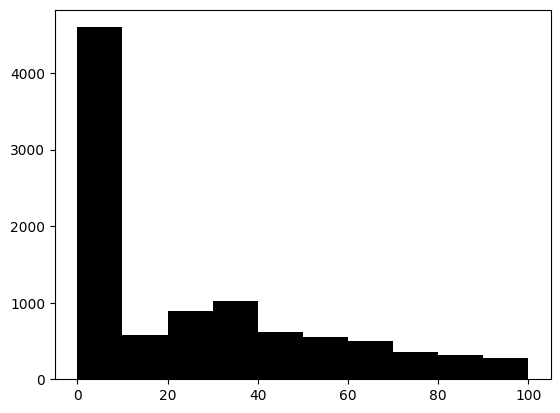

In [2]:
data_dir = "/mnt/local/abrc/parsed_dataset/StomaVision-multilabel"

for f in ["train", "val", "test"]:
    print(f"Processing {f} set")
    img_dir = os.path.join(data_dir, "images", f)
    label_dir = os.path.join(data_dir, "labels", f)
    output_dir = os.path.join(data_dir, "visualization", f)

    isExist = os.path.exists(output_dir)
    if not isExist:
        # Create a new directory because it does not exist
        os.makedirs(output_dir)
        print("output directory is created!")

    # load image names
    ext_map = {}
    imgs = os.listdir(img_dir)
    # extract file extension into a map
    for img in imgs:
        img_name, img_ext = os.path.splitext(img)
        ext_map[img_name] = img_ext

    areas = []
    x_areas = []

    # load label names
    labels = os.listdir(label_dir)
    outer_line_objects = 0
    objects = 0
    ttl = len(labels)
    for idx, label in enumerate(labels):
        print(f"processing data: {idx}/{ttl}")
        if not os.path.isfile(os.path.join(label_dir, label)):
            continue
        lines = []
        polygons = []
        texts = []

        file_name, _ = os.path.splitext(label)
        # Read polygon annotations from a label file
        with open(os.path.join(label_dir, label), "r") as f:
            lines = f.readlines()

        # prepare polygons and texts
        for i, line in enumerate(lines):
            chars = line.split(" ")
            chars = list(map(float, chars))
            polygons.append(chars[1:])
            if int(chars[0]) == 0:
                texts.append("stomata")
            else:
                outer_line_objects += 1
                texts.append("outer_line")

        objects += len(polygons)

        img_file = os.path.join(img_dir, file_name + ext_map[file_name])
        img, sub_areas = draw_polygons(img_file, polygons, texts, thickness=2)

        for a in sub_areas:
            if a <= 3:
                x_areas.append(a)
            if a <= 100:
                areas.append(a)

        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # fig = plt.figure(figsize=(12, 8), dpi=300)
        # plt.axis("off")
        # plt.title("test")
        # plt.imshow(img)
        # plt.imsave(os.path.join(output_dir, file_name + ".png"), img)
        # plt.close(fig)

        cv2.imwrite(os.path.join(output_dir, file_name + ".jpg"), img)

    plt.hist(areas, color="black")
    plt.hist(x_areas, color="black")
    print(f"images: {len(labels)}")
    print(f"objects: {objects}")
    print(f"outer_line_objects: {outer_line_objects}")
    print(
        f"small objects with mask area less than 100: {len(areas)}, percentage: {100*len(areas)/objects}%"
    )
    print(
        f"extreme small objects with mask area less than 3: {len(x_areas)}, percentage: {100*len(x_areas)/objects}%"
    )
    print("==================================================================")